# Refining and Re-ranking the Code Ownership Approximation for Quality Improvement Plans

The statistical analysis was conducted for 6 populations with 50 paired samples.


- Check the normality of the distributions: First all populations are checked with the Shapiro-Wilk test for normality. We use Bonferoni correction for these tests, i.e., alpha/#populations.

The family-wise significance level of the tests is alpha=0.050.

H0:?
H1:?

We rejected the null hypothesis that the population is normal for the populations pop_5 (p=0.000), pop_2 (p=0.000), 
pop_1 (p=0.000), and pop_0 (p=0.000). 
Therefore, we assume that not all populations are normal.

- Test for homogenity

If all columns are normal, we use Bartlett's test for homogeneity, otherwise we use Levene's test.

- Check difference 


Based on the normality and the homogeneity, we select appropriate tests, effect sizes, and methods for determining the confidence intervals of the central tendency.



Because we have more than two populations and the populations and some of them are not normal, we use the 
non-parametric Friedman test as omnibus test to determine if there are any significant differences between the 
median values of the populations. 
We use the post-hoc Nemenyi test to infer which differences are significant. 

We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. 
Differences between populations are significant, if the difference of the mean rank is greater than the critical 
distance CD=1.066 of the Nemenyi test.

We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in the central tendency of 
the populations pop_5 (MD=0.912+-0.154, MAD=0.130, MR=2.180), pop_4 (MD=0.910+-0.173, MAD=0.133, MR=2.290), pop_3 
(MD=0.858+-0.213, MAD=0.210, MR=2.470), pop_2 (MD=0.505+-0.249, MAD=0.334, MR=3.950), pop_1 (MD=0.314+-0.199, 
MAD=0.247, MR=4.710), and pop_0 (MD=0.130+-0.175, MAD=0.192, MR=5.400). Therefore, we assume that there is a 
statistically significant difference between the median values of the populations.


Based on the post-hoc Nemenyi test, we assume that there are no significant differences within the following groups: 
pop_5, pop_4, and pop_3; pop_2 and pop_1; pop_1 and pop_0. All other differences are significant.

In [204]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri, StrVector
pandas2ri.activate()

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=100)

import pandas as pd
Rnalytica = importr('Rnalytica')

features_names = ["COMM","ADEV","DDEV","Added_lines","Del_lines","OWN_LINE","OWN_COMMIT","MINOR_COMMIT",
                  "MINOR_LINE","MAJOR_COMMIT","MAJOR_LINE",
                  "CountDeclMethodPrivate","AvgLineCode","CountLine","MaxCyclomatic","CountDeclMethodDefault",
                  "AvgEssential","CountDeclClassVariable","SumCyclomaticStrict","AvgCyclomatic","AvgLine",
                  "CountDeclClassMethod","AvgLineComment","AvgCyclomaticModified","CountDeclFunction",
                  "CountLineComment","CountDeclClass","CountDeclMethod","SumCyclomaticModified",
                  "CountLineCodeDecl","CountDeclMethodProtected","CountDeclInstanceVariable",
                  "MaxCyclomaticStrict","CountDeclMethodPublic","CountLineCodeExe","SumCyclomatic",
                  "SumEssential","CountStmtDecl","CountLineCode","CountStmtExe","RatioCommentToCode",
                  "CountLineBlank","CountStmt","MaxCyclomaticModified","CountSemicolon","AvgLineBlank",
                  "CountDeclInstanceMethod","AvgCyclomaticStrict","PercentLackOfCohesion","MaxInheritanceTree",
                  "CountClassDerived","CountClassCoupled","CountClassBase","CountInput_Max","CountInput_Mean",
                  "CountInput_Min","CountOutput_Max","CountOutput_Mean","CountOutput_Min","CountPath_Max",
                  "CountPath_Mean","CountPath_Min","MaxNesting_Max","MaxNesting_Mean","MaxNesting_Min"
                  ]

scenarios = [['activemq-5.0.0', 'activemq-5.1.0', 'activemq-5.2.0'],
            ['activemq-5.1.0', 'activemq-5.2.0', 'activemq-5.3.0'],
#             ['activemq-5.2.0', 'activemq-5.3.0', 'activemq-5.8.0'],
            ['camel-1.4.0', 'camel-2.9.0', 'camel-2.10.0'],
            ['camel-2.9.0','camel-2.10.0', 'camel-2.11.0'],
#             ['derby-10.2.1.6', 'derby-10.3.1.4', 'derby-10.5.1.1'],
            ['groovy-1_5_7', 'groovy-1_6_BETA_1', 'groovy-1_6_BETA_2'],
            ['hbase-0.94.0', 'hbase-0.95.0', 'hbase-0.95.2'],
            ['hive-0.10.0', 'hive-0.12.0', 'hive-0.9.0'],
            ['jruby-1.1', 'jruby-1.4.0', 'jruby-1.5.0'],
            ['jruby-1.4.0', 'jruby-1.5.0', 'jruby-1.7.0.preview1'],
            ['lucene-2.3.0', 'lucene-2.9.0', 'lucene-3.0.0'],
            ['lucene-2.9.0', 'lucene-3.0.0', 'lucene-3.1'],
#             ['wicket-1.3.0-beta1', 'wicket-1.3.0-beta2', 'wicket-1.5.3']
        ]

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular

def evaluation_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    auc_ = auc(fpr, tpr)

    y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    prc = precision_score(y_true=y_true, y_pred=y_pred)
    rc = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = 2 * prc * rc / (prc + rc)
    return acc, prc, rc, f1, auc_

def get_tptn(y_test, y_pred):
    df = pd.DataFrame(
        {"y_test" : y_test,
         "y_pred" : y_pred ,
         "prediction": [True if p >= 0.5 else False for p in y_pred] })

    top_tp = df.sort_values(by = 'y_pred', ascending=False)
    top_tp = top_tp[(top_tp['y_test'] ==True) & (top_tp['prediction'] ==True)]
    top_tp = top_tp.index

    top_tn = df.sort_values(by = 'y_pred')
    top_tn = top_tn[(top_tn['y_test'] ==False) & (top_tn['prediction'] ==False)]
    top_tn = top_tn.index

    misclassified = df[(df['y_test'] != df['prediction'])].index.values
    return top_tp, top_tn, misclassified

def parse_explanation(e):
    if len(e.split(' ')) == 3:
        left, condition, right = e.split(' ')
        return [left,condition,right]
    else:
        v1, c1, left, c2, v2 = e.split(' ')
        left, condition, right = left, c1, v1
        if c1 == '<': 
            condition = '>' 
        elif c1 == '<=':
            condition = '>='
        return [left,condition,right]

## RQ4: Which ownership approximations have the strongest impact on software quality?

### For each scenario / classifier

In [206]:
rq4_features = pd.DataFrame(columns=['i','j','technique','SelectedFeature','CorFeatures','Label','Ranking','Importance'])
rq4_models = pd.DataFrame(columns=['i','j','technique','accuracy','precision', 'recall','f1','auc'])

for pair in scenarios:
# pair = scenarios[0]
    release_i, release_j, release_k = pair

    data_train = pd.read_csv('datasets/' + release_i + '.csv')
    features = Rnalytica.AutoSpearman(dataset = data_train[features_names], metrics = rpy2.robjects.StrVector(features_names))

    features_groups = Rnalytica.AutoSpearman(dataset = data_train[features_names], metrics = rpy2.robjects.StrVector(features_names), groups=True)
    features_groups = [list(x) for i, x in enumerate(features_groups)]

    X_train = data_train[features]
    y_train = data_train[['RealBug']].values.ravel()
    X_train, y_train = sm.fit_sample(X_train, y_train)

    data_test = pd.read_csv('datasets/' + release_j + '.csv')
    X_test = data_test[features]
    y_test = data_test[['RealBug']].values.ravel()

    data_validate = pd.read_csv('datasets/' + release_k + '.csv')
    X_validate = data_validate[features]
    y_validate = data_validate[['RealBug']].values.ravel()

    clf = RandomForestClassifier(random_state=100).fit(X_train, y_train)
    

    
    y_pred = clf.predict_proba(X_test)[:, 1]
    acc, prc, rc, f1, auc_ = evaluation_metrics(y_true=y_test, y_pred=y_pred)
    rq4_models = rq4_models.append(pd.DataFrame({
                'i':release_i,
                'j':release_j,
                'technique':'RF',
                'accuracy':acc, 
                'precision':prc, 
                'recall':rc, 
                'f1':f1,
                'auc':auc_.flatten()
            }))
    
    # Normalize to percentage
    df_feature_importance = pd.DataFrame({'Features':features, 'Importance':clf.feature_importances_/sum(clf.feature_importances_)*100})
    ranking = list(df_feature_importance.sort_values(by=['Importance'], ascending=False)['Features'])

    # Analyze RF feature importance based on historical data
    for search in features:
        groups = [element for element in features_groups if search in element and len(features_groups) > 1][0]
        for e in groups:
            rq4_features = rq4_features.append(pd.DataFrame({
                'i':release_i,
                'j':release_j,
                'technique':'RF',
                'SelectedFeature': str(search),
                'CorFeatures':e, 
                'Label': '\n'.join(groups),
                'Ranking': ranking.index(search)+1,
                'Importance':df_feature_importance.loc[df_feature_importance['Features'] == search,'Importance'].values
            }))

In [207]:
rq4_models.to_csv('rq4_models.csv', index=False)
rq4_features.to_csv('rq4_features.csv', index=False)

### Pivot data for running ScottKnott ESD

In [208]:
data = rq4_features.loc[:,['i','CorFeatures','Importance']]
data = data.pivot(index="i", columns = "CorFeatures", values = "Importance").fillna(0).reset_index()
data.index.name = None
data.columns.name = None
data.drop(['i'],axis=1,inplace=True)
data = data.reindex(data.median().sort_values(ascending=False).index, axis=1)
order_by_median = data.columns
data.to_csv('rq4_features_varimp.csv', index=False)

In [15]:
# from rfpimp import *
# imp = rq4_features.loc[:,['Label','Importance']].drop_duplicates()
# imp = imp.set_index('Label').sort_values('Importance', ascending=False)
# viz = plot_importances(imp, xtick_precision=1, width=8, imp_range=(0,0.5))

### Generate plots in R

In [209]:
import subprocess
script_filename = 'RQ4-plots.R'
process = subprocess.Popen(['Rscript', script_filename])
process.wait()

0

## Nemenyi's Test (No statistical difference)

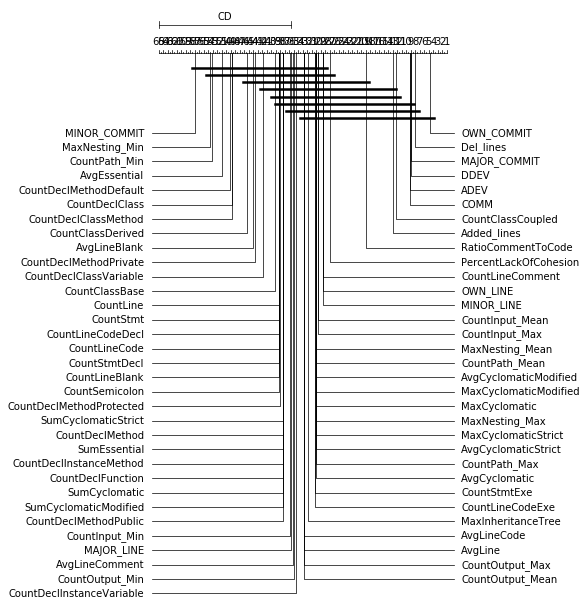

In [27]:
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table
# result = autorank(data, alpha=0.05, verbose=False)
# create_report(result)
# plot_stats(result)
# plt.show()

## RQ5: Should code ownership approximations be used to explain why a file is predicted as defective?

In [205]:
rq5_explanation = []

for pair in scenarios:
    print(pair)
    release_i, release_j, release_k = pair

    data_train = pd.read_csv('datasets/' + release_i + '.csv')
    features = Rnalytica.AutoSpearman(dataset = data_train[features_names], metrics = rpy2.robjects.StrVector(features_names))

    features_groups = Rnalytica.AutoSpearman(dataset = data_train[features_names], metrics = rpy2.robjects.StrVector(features_names), groups=True)
    features_groups = [list(x) for i, x in enumerate(features_groups)]

    X_train = data_train[features]
    y_train = data_train[['RealBug']].values.ravel()
    X_train, y_train = sm.fit_sample(X_train, y_train)

    data_test = pd.read_csv('datasets/' + release_j + '.csv')
    X_test = data_test[features]
    y_test = data_test[['RealBug']].values.ravel()

    data_validate = pd.read_csv('datasets/' + release_k + '.csv')
    X_validate = data_validate[features]
    y_validate = data_validate[['RealBug']].values.ravel()

    clf = RandomForestClassifier(random_state=100).fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.to_numpy(), 
        training_labels=y_train, feature_names=features,
        discretizer='entropy', feature_selection='lasso_path', mode='classification')

    top_tp, top_tn, misclassified = get_tptn(y_test, y_pred)
    
    overlap = set(data_test.loc[top_tp,'File']).intersection(data_validate['File'])
    
    for idx in list(top_tp): #list(top_tp) + list(top_tn) + list(misclassified):
        # if file in the test set exists in the validate set.
        if (data_test.loc[idx,'File'] in overlap) :
            lime_exp = lime_explainer.explain_instance(X_test.to_numpy()[idx], clf.predict_proba, num_features=5)                             

            for e,v in lime_exp.as_list():
                left,condition,right = parse_explanation(e)
                rq5_explanation.append({    
                    'i': release_i,
                    'j': release_j,
                    'k': release_k,
                    'filename': data_test.loc[idx,'File'],
                    'idx': idx,
                    'y_pred': y_pred[idx],
                    'y_test': y_test[idx],                
                    'left': left,
                    'condition': condition,
                    'right': right,
                    'score': v,
                    'X_test': X_test.loc[idx,left],
                    'X_validate': str(data_validate.loc[data_validate['File'] == data_test.loc[idx,'File'], left].values[0]),
                    'y_validate': str(data_validate.loc[data_validate['File'] == data_test.loc[idx,'File'], 'RealBug'].values[0])
                    })
rq5_explanation = pd.DataFrame(rq5_explanation)
rq5_explanation.to_csv('rq5_explanation.csv', index=False)

['activemq-5.0.0', 'activemq-5.1.0', 'activemq-5.2.0']
['activemq-5.1.0', 'activemq-5.2.0', 'activemq-5.3.0']
['camel-1.4.0', 'camel-2.9.0', 'camel-2.10.0']
['camel-2.9.0', 'camel-2.10.0', 'camel-2.11.0']
['groovy-1_5_7', 'groovy-1_6_BETA_1', 'groovy-1_6_BETA_2']
['hbase-0.94.0', 'hbase-0.95.0', 'hbase-0.95.2']
['hive-0.10.0', 'hive-0.12.0', 'hive-0.9.0']
['jruby-1.1', 'jruby-1.4.0', 'jruby-1.5.0']
['jruby-1.4.0', 'jruby-1.5.0', 'jruby-1.7.0.preview1']
['lucene-2.3.0', 'lucene-2.9.0', 'lucene-3.0.0']
['lucene-2.9.0', 'lucene-3.0.0', 'lucene-3.1']


## RQ6: How applicable is the quality improvement plan based on code ownership approximation?


https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}